# DensNet DL modeling on COVID-QU-Ex
In this notebook, we'll study an existing model for image recognition such as DenseNet201 and apply it on our dataset from Kaggle (https://www.kaggle.com/datasets/anasmohammedtahir/covidqu)

FIRST PART: Tunning
- Data will first be analyzed and prepare for modeling.
- The DensNet model from Keras will first be tuned (using KERAS tuner) to optimize its performance.
- The optimized model (known to be the "best" model) will then be trained of train set and validated on val set.
- The model will then be evaluated on the test set.

SECOND PART: Optimisation
- To optimize the model studied in first part, will re-train the model "un-freezing" layers..
- The model will then be evaluated on the test set.

To conclude, we'll compare the "tuned model" and "optimized model"

In [3]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-05-03 11:55:01.233712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 11:55:01.233828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 11:55:01.492414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
# Cell to import necessary library
import numpy as np
import pandas as pd
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn import metrics

import os

In [20]:
import shutil

shutil.rmtree('/kaggle/working/COVID-EX-Qu-dataset/train')

In [5]:
os.remove('/kaggle/working/COVID-EX-Qu-dataset/densenet_baret.h5')

## 1- Data analysis
When first running this notebook, we'll need to transfer images files to the Kaggle working directory.

In [6]:
# This cells is made to set the different directories used in this notebook
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base pat
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data'
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

In [ ]:
# Only run this cell if working files are not in kaggle working directory
import shutil

for sett in sets:
  for group in groups:
    ima_dir = os.path.join(base_path, sett, group)
    for dos in tqdm(os.listdir(ima_dir)):
        if dos=="images":
            shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

In [7]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


# 2- Data preparation

In [8]:
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure image is of type uint8
    img = img.astype('uint8')
    # Equalize histogram
    img = cv2.equalizeHist(img)
    # Convert grayscale back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Preprocess for the model input
    img_preprocessed = preprocess_input(img)
    return img_preprocessed



train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)

In [21]:
# Preparation of the data set using image generator
batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           class_mode="sparse",
                                                           target_size=(224, 224),
                                                           batch_size=batch_size)

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                         class_mode="sparse",
                                                         target_size=(224, 224),
                                                         batch_size=batch_size)

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                          class_mode="sparse",
                                                          target_size=(224, 224),
                                                          batch_size=batch_size, shuffle=False)
        # shuffle=False argument is very important for model evaluation 
        #(I spend many hours trying to figure it out)

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


# 3- DenseNet Model tuning
Due to the significantly high computational duration, only 2 trial were performed to tuned only the 2 dropout rates.

In [15]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import DenseNet201
from  keras_tuner import RandomSearch
from  keras_tuner import HyperParameters
from tensorflow.keras.optimizers import Adam



def build_model():
    
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # Freeze the pre-trained layers so they are not trainable
        for layer in base_model.layers:
            layer.trainable = False
        for layer in base_model.layers[137:]:# Representing the 2 last conv blocks
            layer.trainable = True

        # Create a Sequential model
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation='relu'),
            Dropout(0.2),  
            Dense(128, activation='relu'),
            Dropout(0.2),  
            Dense(3, activation='softmax')  # Output layer with 3 classes
        ])

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001),#Will be set to 0.0001 for fine tuning
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        return model

In [16]:
Model_DNet = build_model()

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
%load_ext tensorboard
log_dir = '/kaggle/working/COVID-EX-Qu-dataset'
tensorboard = TensorBoard(log_dir = log_dir, histogram_freq=1)


early_stopping = EarlyStopping(monitor='val_loss',
                                         patience=3,
                                         mode='min',
                                         restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
nb_img_train = train_generator.samples
nb_img_val = val_generator.samples
history_densenet_nonopt = Model_DNet.fit(train_generator, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=test_generator,
                                validation_steps=nb_img_val//batch_size,
                                callbacks = [tensorboard, reduce_learning_rate]
                                )

Epoch 1/20


W0000 00:00:1714739308.142326     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9201 - loss: 0.2068

W0000 00:00:1714739555.867084     153 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 465s 405ms/step - accuracy: 0.9201 - loss: 0.2067 - val_accuracy: 0.9554 - val_loss: 0.1144 - learning_rate: 1.0000e-04
Epoch 2/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9375 - loss: 0.2094 - val_accuracy: 0.9543 - val_loss: 0.1563 - learning_rate: 1.0000e-04
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 264s 388ms/step - accuracy: 0.9392 - loss: 0.1607 - val_accuracy: 0.9636 - val_loss: 0.1051 - learning_rate: 1.0000e-04
Epoch 4/20
  1/678 ━━━━━━━━━━━━━━━━━━━━ 4:37 410ms/step - accuracy: 0.9062 - loss: 0.2111
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
678/678 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9062 - loss: 0.2111 - val_accuracy: 0.9326 - val_loss: 0.2365 - learning_rate: 1.0000e-04
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 263s 388ms/step - accuracy: 0.9541 - loss: 0.1198 - val_accuracy: 0.9665 - val_loss: 0.0945 - learning_rate: 1.0000e-05
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - acc

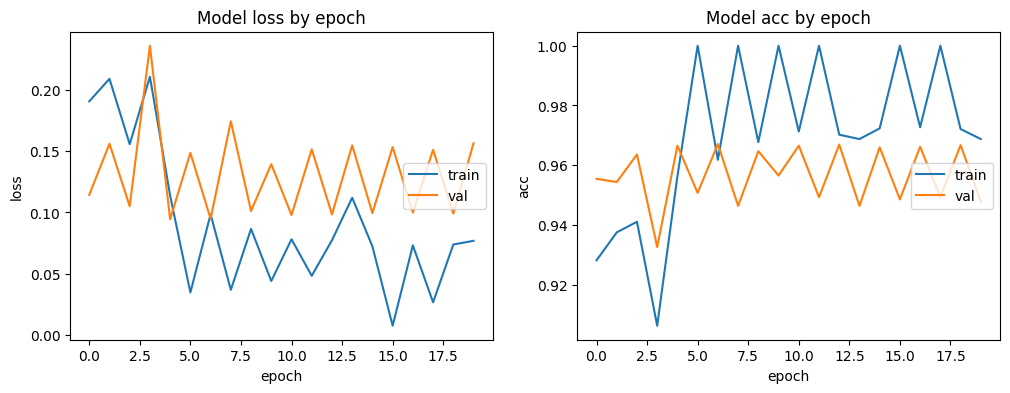

In [25]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_densenet_nonopt.history['loss'])
plt.plot(history_densenet_nonopt.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_densenet_nonopt.history['accuracy'])
plt.plot(history_densenet_nonopt.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [26]:
%reload_ext tensorboard

In [27]:
evaluation = Model_DNet.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - accuracy: 0.9797 - loss: 0.0645
Test Loss: 0.11070481687784195
Test Accuracy: 0.9631702899932861


## 5- RESULTS

In [28]:
# After model training
Model_DNet.save('/kaggle/working/COVID-EX-Qu-dataset/Models/DNet_baret.h5')  # saves the entire model to a HDF5 file

ValueError: Unable to synchronously create dataset (name already exists)

  2/213 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step  

W0000 00:00:1714742301.655871     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/213 ━━━━━━━━━━━━━━━━━━━━ 60s 201ms/step


W0000 00:00:1714742344.327341     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2395
           1       0.94      0.96      0.95      2253
           2       0.96      0.94      0.95      2140

    accuracy                           0.96      6788
   macro avg       0.96      0.96      0.96      6788
weighted avg       0.96      0.96      0.96      6788



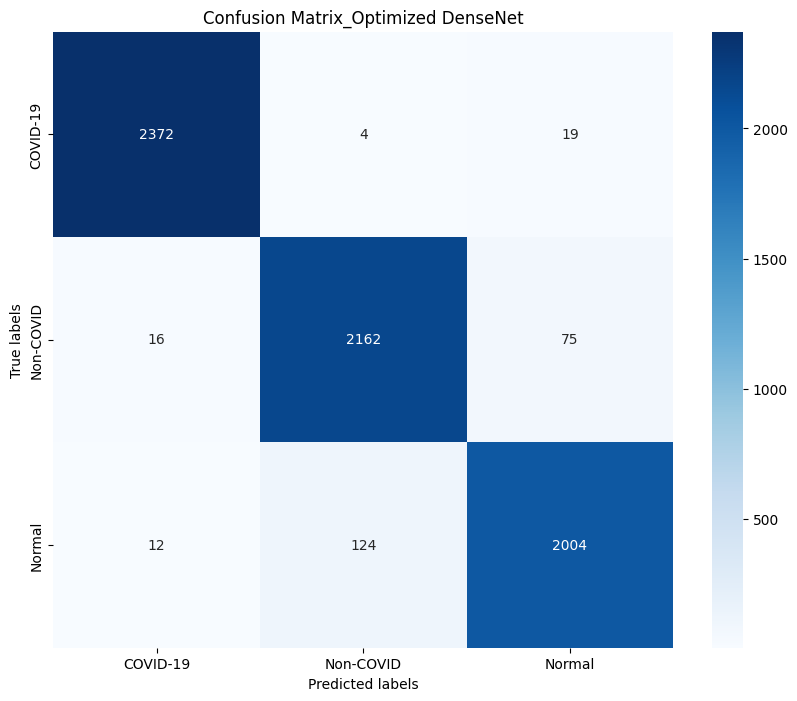

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions on the test data
predictions = Model_DNet.predict(test_generator)
# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)
# Get the true classes
true_classes = test_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(classification_report(true_classes, predicted_classes))
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix_Optimized DenseNet')
plt.show()